# Keras CIFAR-10 dataset solution

In [15]:
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import model_from_json
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import scikitplot as skplt

In [16]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Number of training examples: 50000
Number of testing examples: 10000
Number of classes: 10
Image shape: (32, 32, 3)
Image data type: uint8


<BarContainer object of 10 artists>

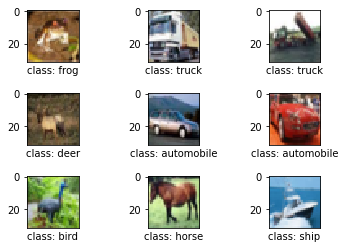

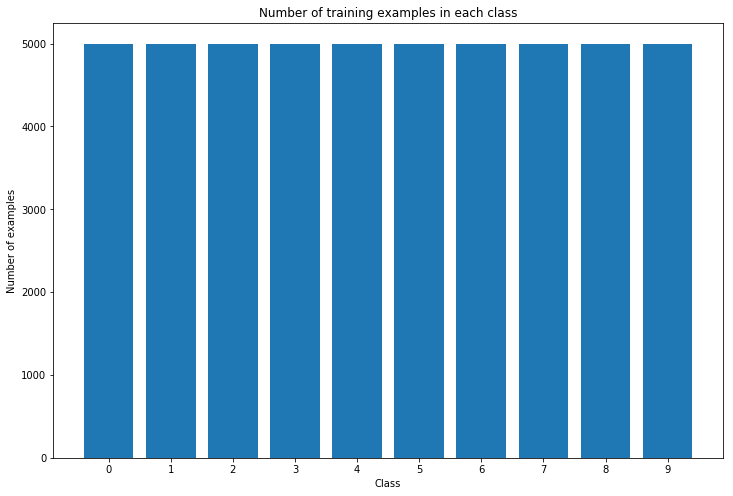

In [17]:
# Visualize
fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

class_to_label =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(train_images[i])

    # Name of the true class.
    cls_true_name = class_to_label[train_labels[i][0]]
    xlabel = "class: {0}".format(cls_true_name)

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])
    
num_classes = np.unique(train_labels).shape[0]
print("Number of training examples:", train_images.shape[0])
print("Number of testing examples:", test_images.shape[0])
print("Number of classes:", num_classes)
print("Image shape:", train_images[0].shape)
print("Image data type:", train_images.dtype)
    
reshaped_labels = [class_num[0] for class_num in train_labels]
class_distribution = Counter(reshaped_labels)
x = range(10)
y = [class_distribution[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of training examples in each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, y)

In [18]:
num_classes = 10
# Convert class vectors to binary class matrices.
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [19]:
# Data agumentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_images)

In [20]:
# Normalization
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

In [21]:
# Train weights
def fit_save_network(network, epochs, name=None):
    ''' Fit and save a network, or load from disk '''
    print()
    network.summary()
    if not os.path.isfile('{}.csv'.format(str(name))) or not os.path.isfile('{}.h5'.format(str(name))):
        csv_logger = CSVLogger('{}.csv'.format(str(name)), 
                               separator=',', 
                               append=False)
        network.fit(train_images, train_labels,
                  batch_size=128,
                  epochs=epochs,
                  validation_split = 0.25,
                  callbacks = [csv_logger])
        # serialize weights to HDF5
        network.save_weights('{}.h5'.format(str(name)))
        print('Saved model to disk')
        history = network.history.history
    else:
        log_data = pd.read_csv('{}.csv'.format(str(name)), 
                               sep=',', 
                               engine='python')
        network.load_weights('{}.h5'.format(str(name)))
        print('Loaded model from disk')
        history = log_data

    test_loss, test_acc = network.evaluate(test_images, test_labels)
    print('test_acc:', test_acc)

    return network, history

## Best MNIST on the CIFAR10 dataset

In [22]:
network = models.Sequential()

network.add(layers.Flatten(input_shape=train_images.shape[1:]))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

epochs = 10
network, history = fit_save_network(network, epochs, 'mnist_old')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               786688    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________

In [24]:
score = network.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (network.metrics_names[1], score[1]*100))

acc: 40.62%


10000/10000 [==============================] - 1s 93us/step
The final loss on the test set is: 1.683736079788208
The final accuracy on the test set is: 0.4062


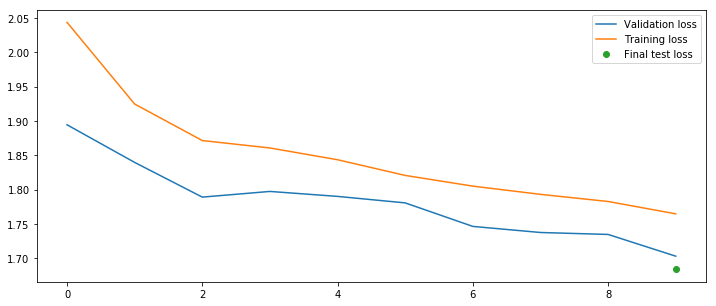

In [27]:
final_loss, final_accuracy = network.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

## Simple model, >70% accuracy

In [50]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:]))
model.add(Activation('relu'))
x = Conv2D(32, (3, 3))
model.add(x)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_32 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_33 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [53]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
epochs = 60
model, history = fit_save_network(model, epochs, 'simplenew60')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_32 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_33 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 15, 15, 64)        18496     
_________

Epoch 43/60
37500/37500 [==============================] - 18s 484us/step - loss: 0.8661 - acc: 0.6999 - val_loss: 0.8682 - val_acc: 0.7009
Epoch 44/60
37500/37500 [==============================] - 18s 482us/step - loss: 0.8606 - acc: 0.7032 - val_loss: 0.8650 - val_acc: 0.6980
Epoch 45/60
37500/37500 [==============================] - 18s 488us/step - loss: 0.8506 - acc: 0.7089 - val_loss: 0.8874 - val_acc: 0.6954
Epoch 46/60
37500/37500 [==============================] - 18s 484us/step - loss: 0.8512 - acc: 0.7075 - val_loss: 0.8759 - val_acc: 0.6934
Epoch 47/60
37500/37500 [==============================] - 18s 482us/step - loss: 0.8437 - acc: 0.7097 - val_loss: 0.8558 - val_acc: 0.7029
Epoch 48/60
37500/37500 [==============================] - 18s 481us/step - loss: 0.8356 - acc: 0.7111 - val_loss: 0.8484 - val_acc: 0.7043
Epoch 49/60
37500/37500 [==============================] - 18s 482us/step - loss: 0.8333 - acc: 0.7149 - val_loss: 0.8382 - val_acc: 0.7113
Epoch 50/60
37500/37

In [54]:
score = model.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 72.09%


10000/10000 [==============================] - 2s 189us/step
The final loss on the test set is: 0.8122079083442688
The final accuracy on the test set is: 0.7209


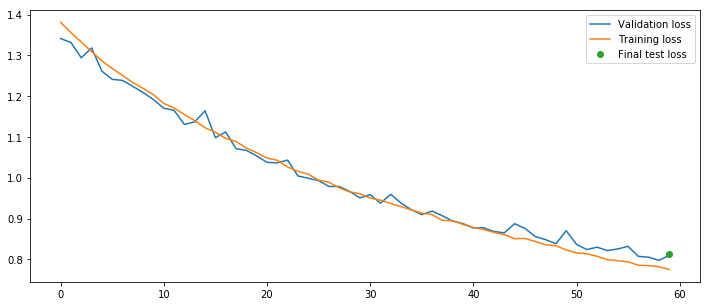

In [56]:
final_loss, final_accuracy = model.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

# Complex model, ~85% accuracy

In [14]:
# Heavy best model:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

epochs = 50
model, history = fit_save_network(model, epochs, "best")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________

# Evaluation

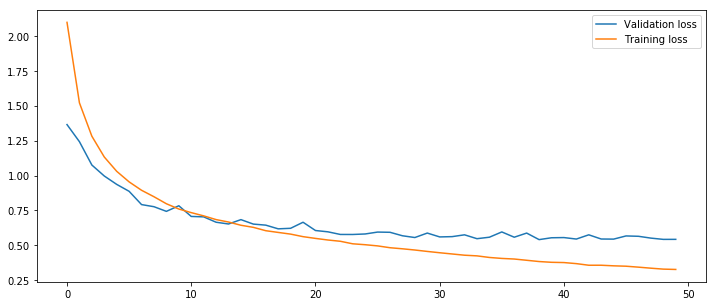

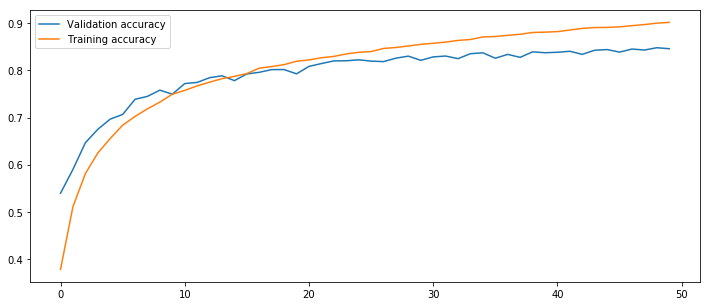

10000/10000 [==============================] - 3s 331us/step
The final loss on the test set is: 0.5430691559791565
The final accuracy on the test set is: 0.8456


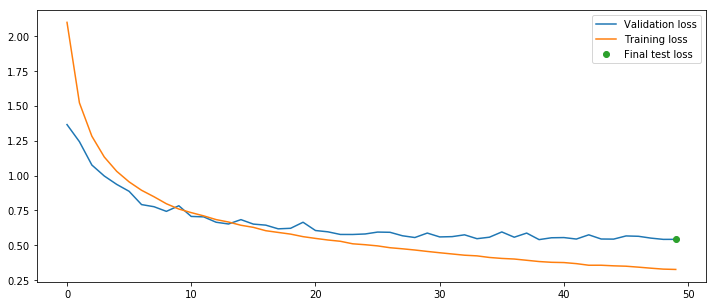

In [15]:
''' Visulize loss and acurracy for a network '''
# plot losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.legend()
plt.show()

# plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history['val_acc'], label='Validation accuracy')
plt.plot(history['acc'], label='Training accuracy')
plt.legend()
plt.show()

final_loss, final_accuracy = model.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()

## More evaluation

In [16]:
def plot_classification_report(plotMat, classes):
    ''' Plots the classification report from scikit-learn as a heatmap '''
    title='Precision-recall report'
    plt.figure(figsize=(10, 5))
    plt.imshow(plotMat, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title)
    plt.colorbar(orientation='horizontal')
    y_tick_marks = np.arange(3)
    x_tick_marks = np.arange(len(classes))
    plt.yticks(y_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.xticks(x_tick_marks, classes)
    #plt.tight_layout()
    plt.xlabel('Classes')
    plt.ylabel('Measures')
    plt.show()

10000/10000 [==============================] - 3s 255us/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.93      0.92      0.92      1000
           2       0.78      0.80      0.79      1000
           3       0.73      0.68      0.70      1000
           4       0.80      0.85      0.82      1000
           5       0.76      0.76      0.76      1000
           6       0.87      0.91      0.89      1000
           7       0.91      0.89      0.90      1000
           8       0.88      0.93      0.91      1000
           9       0.93      0.88      0.91      1000

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



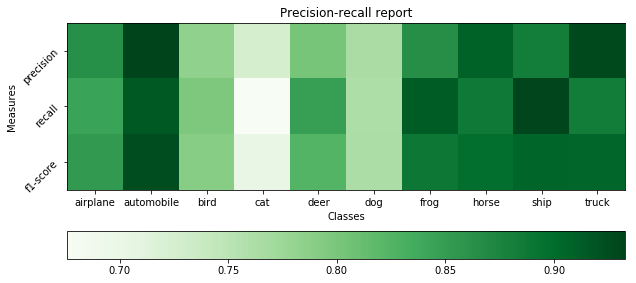

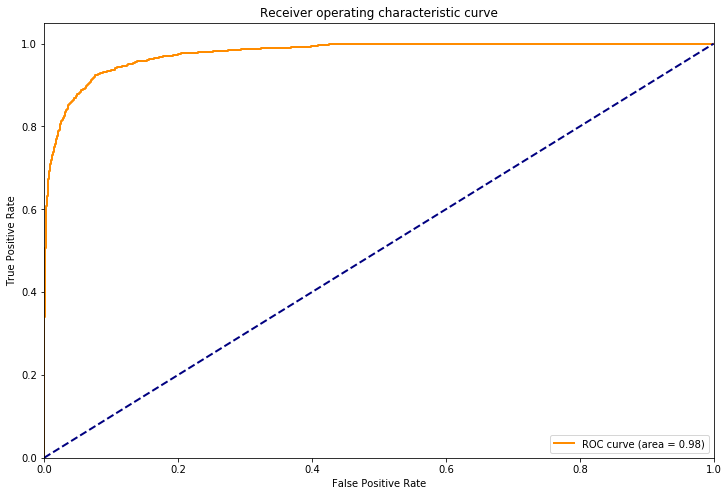

In [48]:
def visualize_precision_recall(network, epochs):
    ''' Visualizes precision-recall in as a heatmap and showing the ROC-curve
    ''' 
    #test_score = history.decision_function(test_images)
    pred = network.predict(test_images, batch_size=128, verbose=1)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(test_labels, axis=1),
            predicted)
    probas = network.predict_proba(test_images)
    print(report)

    # need to do this again to get the dictionary for plots :S
    report = classification_report(np.argmax(test_labels, axis=1), predicted, output_dict=True)

    plotMat = []
    classes =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    precision = []
    recall = []
    f1 = []
    for k, v in report.items():
        precision.append(v.get('precision'))
        recall.append(v.get('recall'))
        f1.append(v.get('f1-score'))
    plotMat.append(precision[:10])
    plotMat.append(recall[:10])
    plotMat.append(f1[:10])
    plot_classification_report(plotMat, classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(),
            probas.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure(figsize=(12, 8))
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    
visualize_precision_recall(model, epochs)

## Implementation of a known model on CIFAR-10

In [49]:
vgg = keras.applications.vgg16.VGG16(include_top=False,
weights='imagenet',
input_shape=train_images.shape[1:])
for layer in vgg.layers[:-2]:
    layer.trainable = False
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [50]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
epochs = 40
model, history = fit_save_network(model, epochs, 'known')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 14,719,818
Trainable params: 2,364,938
Non-trainable params: 12,354,880
_________________________________________________________________
Train on 37500 samples, validate on 12500 samples
Epoch 1/40
37500/37500 [==============================] - 56s 1ms/step - loss: 1.3525 - acc: 0.5365 - val_loss: 1.1975 - val_acc: 0.5862
Epoch 2/40
37500/37500 [==============================] - 54s 1ms/step - loss: 1.1054 - acc: 0.6180 - val_loss: 1.0685 - val_acc: 0.6290
Epoch 3/40
37500/37500 [==============================] - 55s

10000/10000 [==============================] - 10s 963us/step
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      1000
           1       0.79      0.75      0.77      1000
           2       0.62      0.64      0.63      1000
           3       0.54      0.52      0.53      1000
           4       0.63      0.64      0.63      1000
           5       0.57      0.62      0.59      1000
           6       0.72      0.71      0.72      1000
           7       0.87      0.61      0.72      1000
           8       0.80      0.79      0.79      1000
           9       0.75      0.71      0.73      1000

   micro avg       0.68      0.68      0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



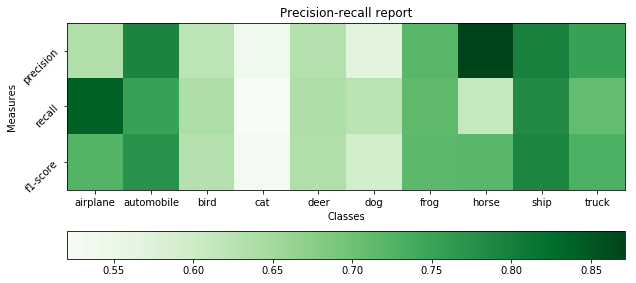

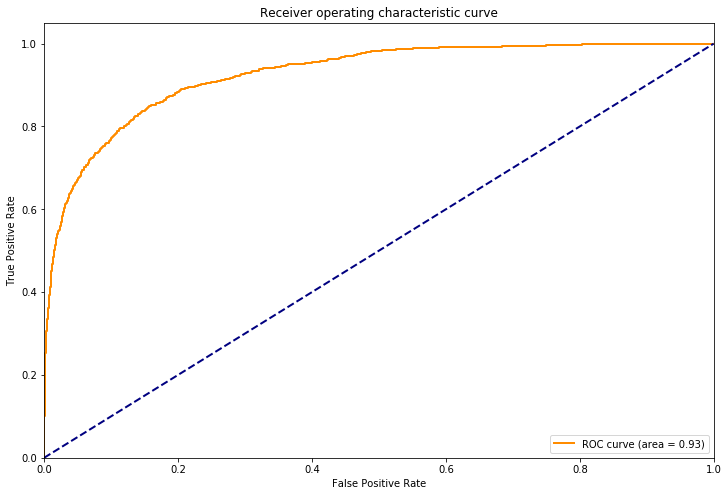

In [51]:
visualize_precision_recall(model, epochs)

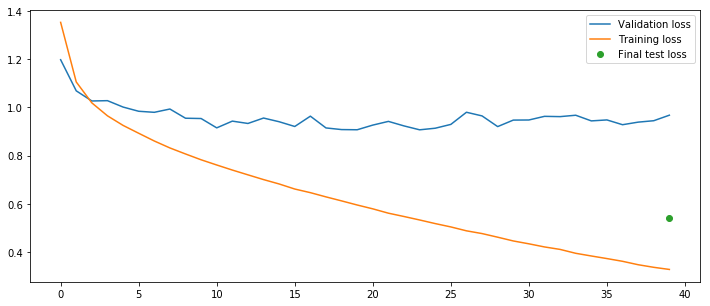

In [52]:
# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([epochs-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()